In [ ]:
pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.1 MB/s 


In [165]:
pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.4 MB/s 
     |████████████████████████████████| 133 kB 48.5 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=7fe6588a1434229ce3eee795d17b43d2a355d15e97e6499a175412e6fb98c085
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompa

In [211]:
pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 5.2 MB/s 
     |████████████████████████████████| 77 kB 3.9 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=4c87534545982375212a2de4f3740ee74a2cd4414b792c4c19f70de961859aa7
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.5 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 

In [263]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sksurv.ensemble import RandomSurvivalForest 
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.pipeline import  make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from scipy.stats import ranksums
from sklearn.feature_selection import RFECV
#-----------------model for regression---------------------------------
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
#-----------------model for survival-----------------------------------
from sksurv.linear_model import CoxPHSurvivalAnalysis
#------------------------------------------------------------------------
import eli5
from eli5.sklearn import PermutationImportance
import statistics
from sksurv.nonparametric import kaplan_meier_estimator
from lifelines.statistics import pairwise_logrank_test
from sklearn.metrics import make_scorer
from sksurv.metrics import concordance_index_censored,concordance_index_ipcw
from sklearn.preprocessing import StandardScaler

In [81]:
def rfecv(model, x_train, y_train):
  r = RFECV(estimator = model, step = 8, cv = 3, scoring = 'neg_mean_squared_error').fit(x_train, y_train)
  print("Optimal number of features : %d" % r.n_features_)
  print("Support : %s" % r.support_)
  print("Ranking : %s" % r.ranking_)

  return r.n_features_, r.support_

In [63]:
def C_indicator(model, x_train, y_train, y_trstatus, y_trtime, x_test, y_test, y_testatus, y_tetime):
  
  #modeling
  model.fit(x_train, y_train)

  #train
  train_pre = model.predict(x_train)
  tr_c_index, tr_iccd, tr_idcd, tr_iti_risk, tr_iti_time = concordance_index_censored(y_trstatus > 0, y_trtime, train_pre)
  tr_c_ipcw, tr_pccd, tr_pdcd, tr_pti_risk, tr_pti_time = concordance_index_ipcw(y_train, y_train, train_pre)
  
  #test
  test_pre = model.predict(x_test)
  te_c_index, te_iccd, te_idcd, te_iti_risk, te_iti_time = concordance_index_censored(y_testatus > 0, y_tetime, test_pre)
  te_c_ipcw, te_pccd, te_pdcd, te_pti_risk, te_pti_time = concordance_index_ipcw(y_train, y_test, test_pre)

  #combine
  result = {
        "C-index":[tr_c_index, te_c_index],
        "C-ipcw":[tr_c_ipcw, te_c_ipcw]
  }

  indicator = pd.DataFrame(result)
  indicator.index = ['training', 'test']
  indicator.round(3)
  print(indicator)



In [100]:
def regre_peform(regre_model, sur_model, x_train, y_train_struct, ystatus_train, ytime_train, x_test, y_test_struct, ystatus_test, ytime_test):

  x_pretrain = x_train.values
  n_feature, selected = rfecv(regre_model, x_pretrain, ytime_train)

  trfeature = x_train.loc[:, selected]
  tefeature = x_test.loc[:, selected]

  C_indicator(sur_model, trfeature, y_train_struct, ystatus_train, ytime_train, tefeature, y_test_struct, ystatus_test, ytime_test)

  return trfeature.columns, cox.coef_

In [225]:
def km_logrank(inter, X_train, y_train_struct):

  gene = X_train[inter]
  median = statistics.median(gene)
  for i in train_index:
    if gene.loc[i] >= median:
      gene.loc[i] = "High expression"
    else:
      gene.loc[i] = "Low expression"

  for expression in ("High expression","Low expression"):
    mask_treat = gene == expression
    time_treat, survival_prob_treat = kaplan_meier_estimator(y_train_struct["Status"][mask_treat],y_train_struct["Survival"][mask_treat])
    plt.step(time_treat, survival_prob_treat, where="post",label=expression)
  
  log_rank = pairwise_logrank_test(y_train_struct["Status"], gene, y_train_struct["Survival"])
  print(log_rank.summary)

  plt.ylabel("est. probability of survival $\hat{S}(t)$")
  plt.xlabel("time $t$")
  plt.legend(loc="best")

In [78]:
#no use
def embedded(model, threshold, x_train, y_train):
  score = []
  best_threshold = threshold[0]
  best_score = 0

  for i in threshold:
    x_embedded = SelectFromModel(model, threshold = i).fit_transform(x_train, y_train)
    model.fit(x_embedded, y_train)
    now_score = model.score(x_embedded, y_train)
    score.append(now_score)
    if(now_score > best_score): 
      best_score = now_score
      best_threshold = i

  print(best_threshold)
  print(best_score)
  plt.plot(threshold, score)
  plt.show()

In [262]:
def my_cross_val(model, x_train, y_train, cv):

  cvs = 0
  record = []
  num_val_samples = len(x_train)//cv

  for i in range(cv):
      val_data = x_train[i*num_val_samples : (i+1)*num_val_samples]
      val_targets = y_train[i*num_val_samples : (i+1)*num_val_samples]
      
      remaining_data = np.concatenate( 
                          [x_train[: i*num_val_samples],
                          x_train[(i+1)*num_val_samples :]],
                          axis = 0)
      remaining_targets = np.concatenate(
                          [y_train[: i*num_val_samples],
                          y_train[(i+1)*num_val_samples :]],
                          axis = 0)
      # print(i)
      # print(remaining_data.shape)
      # print(remaining_targets.shape)
      model.fit(remaining_data, remaining_targets)
      record.append(model.score(val_data, val_targets))
  
  for i in record:
    cvs += (i/cv)
  
  return cvs

In [261]:
def c_index_scoring(model, x_train, y_train):
  model.fit(x_train, y_train)
  return model.score(x_train, y_train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [236]:
raw_data = pd.read_excel("/content/drive/My Drive/TCGA-STAD_recurrence.xlsx",sheet_name="all")
raw_data

,ENSG00000082929.8,ENSG00000083622.8,ENSG00000093100.13,ENSG00000099869.8,ENSG00000103472.10,ENSG00000115934.11,ENSG00000116652.6,ENSG00000117242.7,ENSG00000120664.11,ENSG00000122043.11,...,ENSG00000288648.1,ENSG00000288657.1,ENSG00000288659.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288667.1,ENSG00000288670.1,Overall Survival Status,Overall Survival (Months),recurrence
0,0.0000,0.1692,0.0441,0.0000,0.1541,0.0000,0.1432,1.7975,0.0127,0.0321,...,0.0000,0.0000,0.0000,1.5909,0.1675,1.0432,4.6662,0,1.150672,0
1,0.2205,0.5120,0.1483,0.0447,0.4239,0.0000,0.2888,1.5599,0.0319,0.0000,...,0.0000,0.0000,0.0000,7.4869,0.0732,1.0520,6.9784,0,13.577933,0
2,0.1012,0.5223,0.2995,0.0000,0.2594,0.0000,0.5855,3.2796,0.1406,0.4758,...,0.0000,0.0000,0.0000,1.9638,0.4617,3.2193,6.0641,1,16.306671,-1
3,0.0999,0.0000,0.0896,0.0811,0.4098,0.0000,0.2072,1.6058,0.2467,0.3132,...,0.0000,0.0843,0.3970,5.1700,0.3674,6.3566,3.0471,0,0.953414,0
4,0.1534,0.9495,0.2681,0.0000,0.1179,0.0000,0.3515,2.5412,0.1065,0.0000,...,0.0000,0.0194,0.0000,2.2313,0.1801,0.0000,11.9283,1,17.523096,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0.0000,0.2273,0.0000,0.0000,0.3199,0.0000,0.1322,4.9149,0.0000,0.0216,...,0.0000,0.0000,0.0000,0.7122,0.2100,1.4011,3.7366,0,18.377881,0
348,0.2519,0.0000,0.0000,0.0000,0.5164,0.0000,0.1649,1.3197,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.2744,4.8060,3.4071,0,19.528553,0
349,0.7716,1.1944,0.1186,0.5143,0.3955,0.2896,0.4512,3.0323,0.4465,0.4210,...,0.5284,0.3346,0.5474,2.1385,0.7430,2.1034,7.0297,1,7.725943,-1
350,0.0000,0.3930,0.0455,0.0858,0.0976,0.0185,0.4641,1.3635,0.0441,0.0000,...,0.0000,0.0000,0.0000,5.7461,0.3759,1.6148,3.5433,0,13.512181,0


In [237]:
x = raw_data.iloc[:,0:-3]
y_recur = raw_data.iloc[:,-1]
y_time = raw_data.iloc[:,-2]
y_status = raw_data.iloc[:,-3]
y_label = raw_data.iloc[:,-3:-1]

In [238]:
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=0)
for train_index, test_index in sss.split(x, y_recur):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = x.iloc[train_index,:], x.iloc[test_index,:]
  y_train, y_test = y_recur[train_index], y_recur[test_index]

TRAIN: [ 51 162 347 327  84   1 123  43  81  34 282 146 336 204 318 247 108  76
 148  79  28  99 143  31 203 141 340 244 278 314  89 239 333 126 100 330
 248 242 120  56 297 236  61 102 303 344  75 281  14 350 156  57 238 174
 257 231 115 346 307 196 348  74 263  87  50 332  85  90   4  12 216 284
 136 329  47  25  27 139 287 142 285 119 112  35 168 272 299  95 328 134
 164  22  54 232  69 268  41 322 265  15  93  52 245 147 296 230  38 338
 325 166 140 258 304 256  92 274 199 111 171  88 154 264 224 135 260 149
 118 177  64 170 321 290 243 169 190 259  98 319 155 237 276 254 188 251
  77 298 235 315 301 300 215 189 225 176 255 218 173 220  23 185  29 289
  73  17  16   8 191  80 145 253 323 335 179  45  63 117  65 266 207 125
  97 194 217  13 250 160 308 101 159 103 113   6 219   9 157 295   7   5
 193 198 334 306 114 131 280 291 339 129  96 226 261 202  44   0 294 158
 186 183 349  21  67   2 197 201 249  86 292  53  62 286 277 128 311 137
 293 345 212  18  83 110 288  20 316 104 192

In [ ]:
df_ranksum = pd.concat([X_train,y_train], axis = 1)
filter = df_ranksum["recurrence"] != -1 #
df = df_ranksum[filter]

In [ ]:
print(df)

In [97]:
titles = list(df.iloc[:,0:-1].columns)
drop = list(df.iloc[:,-1])
df = df
p01_name=[]
c=0
for i in titles:
    #print(i)
    value1=[]
    value0=[]
    my_col = df[[i,"recurrence"]]
    
    
    for j in range(0,my_col.shape[0]):
        if (str(my_col.iloc[j,1]) == "1"):
            value1.append(my_col.iloc[j,0])
        else:
            value0.append(my_col.iloc[j,0])
    value0 = np.array(value0) 
    value1 = np.array(value1)
    ttt = ranksums(value0,value1)
    if ttt.pvalue<0.01:
      c=c+1
      p01_name.append(i)
print(c)
print(p01_name)

844
['ENSG00000082929.8', 'ENSG00000132832.10', 'ENSG00000166770.11', 'ENSG00000174325.6', 'ENSG00000175967.4', 'ENSG00000176659.9', 'ENSG00000177822.8', 'ENSG00000178722.13', 'ENSG00000179136.7', 'ENSG00000180259.10', 'ENSG00000180769.10', 'ENSG00000181800.6', 'ENSG00000181908.5', 'ENSG00000182376.2', 'ENSG00000183242.12', 'ENSG00000187621.15', 'ENSG00000188511.12', 'ENSG00000196166.5', 'ENSG00000196979.1', 'ENSG00000197291.9', 'ENSG00000197813.6', 'ENSG00000198106.8', 'ENSG00000198358.4', 'ENSG00000203434.2', 'ENSG00000203506.5', 'ENSG00000203709.12', 'ENSG00000203930.12', 'ENSG00000203987.3', 'ENSG00000204091.8', 'ENSG00000204110.6', 'ENSG00000204241.8', 'ENSG00000204283.4', 'ENSG00000204446.4', 'ENSG00000205018.2', 'ENSG00000205037.2', 'ENSG00000205325.3', 'ENSG00000205549.10', 'ENSG00000205562.3', 'ENSG00000205971.3', 'ENSG00000206417.8', 'ENSG00000207955.5', 'ENSG00000213279.2', 'ENSG00000214188.9', 'ENSG00000214546.4', 'ENSG00000214548.18', 'ENSG00000214650.3', 'ENSG00000214851.

In [98]:
x_train = X_train[p01_name]
x_test = X_test[p01_name]

# y_train, y_test 為訓練和推論使用的正式答案(狀態+時間)
ytime_train = y_time[train_index]
ytime_test = y_time[test_index]
ystatus_train = y_status[train_index]
ystatus_test = y_status[test_index]
y_train = y_label.loc[train_index]
y_test = y_label.loc[test_index]
# print(x_train)
# print(ytime_train)

In [99]:
y_train_struct = y_train.to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])
y_test_struct = y_test.to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])

In [104]:
xgbr = XGBRegressor(objective='reg:squarederror')
cox = CoxPHSurvivalAnalysis(alpha = 0.1)

xgbr_selected, xgb_coef = regre_peform(xgbr, cox, x_train, y_train_struct, ystatus_train, ytime_train, x_test, y_test_struct, ystatus_test, ytime_test)

Optimal number of features : 244
Support : [False  True  True False False False False  True False False  True False
 False  True  True  True False False False  True  True False  True False
 False False  True  True False  True False False False False False  True
  True  True  True  True False  True  True False False False  True  True
  True False  True False  True False  True False False False False False
 False False False False False False False False False False False False
  True False False  True  True False  True  True  True False  True False
  True  True False  True  True False False False False False False False
  True False False False False False False False  True False  True False
 False  True False  True False False False False  True  True False False
 False False False False False False False False False  True False False
 False False False  True False False  True False False  True False False
 False  True  True  True False False False False False False  True False
 False  

In [ ]:
# print(xgbr_selected)
# print(xgb_coef)

In [108]:
gbr = GradientBoostingRegressor()
cox = CoxPHSurvivalAnalysis(alpha = 0.00001)

gbr_selected, gbr_coef = regre_peform(gbr, cox, x_train, y_train_struct, ystatus_train, ytime_train, x_test, y_test_struct, ystatus_test, ytime_test)

Optimal number of features : 52
Support : [False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False  True False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False Fa

In [113]:
sgd = SGDRegressor()
cox = CoxPHSurvivalAnalysis(alpha = 0.00001)

sgd_selected, sgd_coef = regre_peform(sgd, cox, x_train, y_train_struct, ystatus_train, ytime_train, x_test, y_test_struct, ystatus_test, ytime_test)

Optimal number of features : 1
Support : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False Fal

In [118]:
svr = SVR(kernel = 'linear')
cox = CoxPHSurvivalAnalysis(alpha = 0.00001)

svr_selected, svr_coef = regre_peform(svr, cox, x_train, y_train_struct, ystatus_train, ytime_train, x_test, y_test_struct, ystatus_test, ytime_test)

Optimal number of features : 4
Support : [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False Fal

In [122]:
coxPH_x_train = x_train.loc[:, gbr_selected]
coxPH_x_test = x_test.loc[:, gbr_selected]

breslow
86.08609522522522
0.6016652760032903


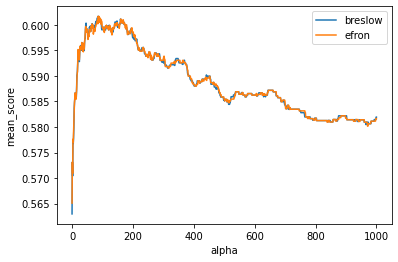

In [144]:
alpha = np.linspace(0.00001, 1000, 1000)
bre_score = []
efr_score = []
best_score = 0
best_alpha = 0
best_tie = ""

for t in ["breslow", "efron"]:
  for i in alpha:
    cox = CoxPHSurvivalAnalysis(alpha = i, ties = t, n_iter = 200)
    now_score = my_cross_val(cox, coxPH_x_train, y_train_struct, 5)
    if(t == 'breslow'): bre_score.append(now_score)
    else: efr_score.append(now_score)
    
    if(now_score > best_score):
      best_tie = t
      best_score = now_score
      best_alpha = i

print(best_tie)
print(best_alpha)
print(best_score)

plt.plot()
breslow, = plt.plot(alpha, bre_score, label = 'breslow')
efron, = plt.plot(alpha, efr_score, label = 'efron')
plt.xlabel('alpha')
plt.ylabel('mean_score')
plt.legend(handles = [breslow, efron], loc='upper right')
plt.show()

In [274]:
cox = CoxPHSurvivalAnalysis(alpha = 86.08609522522522, ties = 'breslow', n_iter = 200)
C_indicator(cox, coxPH_x_train, y_train_struct, ystatus_train, ytime_train, coxPH_x_test, y_test_struct, ystatus_test, ytime_test)

           C-index    C-ipcw
training  0.667403  0.689030
test      0.595593  0.581848


In [173]:
cox = CoxPHSurvivalAnalysis(alpha = 86.08609522522522, ties = 'breslow', n_iter = 200).fit(coxPH_x_train, y_train_struct)
importance = PermutationImportance(cox, random_state=1).fit(coxPH_x_test, y_test_struct)
eli5.show_weights(importance, feature_names = coxPH_x_test.columns.tolist())

Weight,Feature
0.1031 ± 0.0427,ENSG00000229953.1
0.0328 ± 0.0507,ENSG00000230479.1
0.0193 ± 0.0105,ENSG00000263588.1
0.0188 ± 0.0129,ENSG00000272405.1
0.0167 ± 0.0092,ENSG00000232079.7
0.0165 ± 0.0141,ENSG00000251129.2
0.0145 ± 0.0118,ENSG00000244137.1
0.0127 ± 0.0057,ENSG00000233818.1
0.0103 ± 0.0103,ENSG00000256001.2
0.0081 ± 0.0060,ENSG00000259436.1


                                test_statistic        p   -log2(p)
High expression Low expression       12.272727  0.00046  11.087252


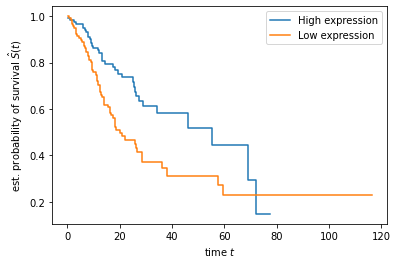

In [239]:
km_logrank('ENSG00000229953.1', X_train, y_train_struct)

                                test_statistic         p  -log2(p)
High expression Low expression         4.86532  0.027402   5.18959


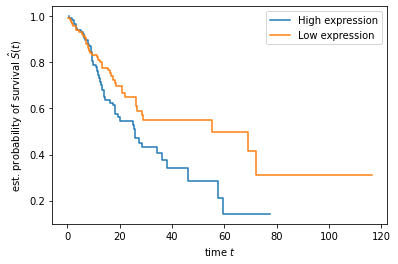

In [240]:
km_logrank('ENSG00000230479.1', X_train, y_train_struct)

                                test_statistic         p  -log2(p)
High expression Low expression        2.845118  0.091652  3.447692


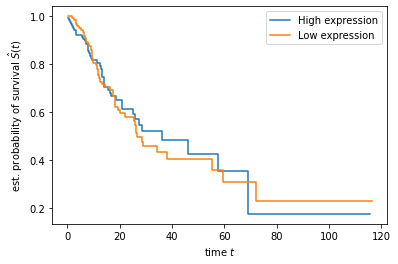

In [241]:
km_logrank('ENSG00000263588.1', X_train, y_train_struct)

                                test_statistic         p  -log2(p)
High expression Low expression        6.077441  0.013692  6.190534


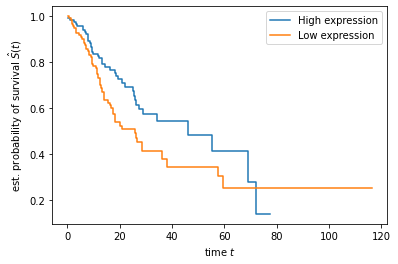

In [242]:
km_logrank('ENSG00000272405.1', X_train, y_train_struct)

                                test_statistic         p  -log2(p)
High expression Low expression        1.363636  0.242908  2.041517


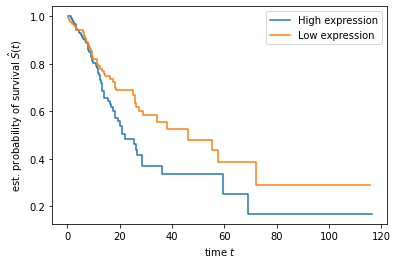

In [243]:
km_logrank('ENSG00000232079.7', X_train, y_train_struct)

存模型

In [264]:
from joblib import dump, load

In [268]:
dump(cox, 'cox.joblib')

['cox.joblib']

In [269]:
test_model = load('cox.joblib')

存特徵

In [284]:
coxPH_x_train.to_csv('/content/drive/My Drive/features_cox.csv')